In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.linear_model
import string
#import pandas to load csv data 
import pandas as pd
import torch

In [21]:
data_dir = "/Users/fionalmeyda/Desktop/homework5_MATH/"
df_train = pd.read_csv(data_dir + "mnist_train.csv")
df_test = pd.read_csv(data_dir + "mnist_test.csv")

In [22]:
class DigitsDataset(torch.utils.data.Dataset):
    
    def __init__(self,df):
        self.df =df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        x = np.float32(row[1:].values)/255.0
        y =row[0]
        return x,y    

In [23]:
dataset_train= DigitsDataset(df_train)
dataset_test = DigitsDataset(df_test)

dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=64,shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test,batch_size=64,shuffle=True)

tensor(6)


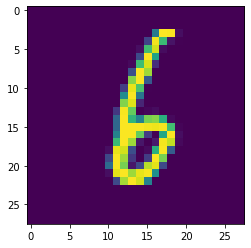

In [24]:
X_batch, Y_batch = next(iter(dataloader_train))
plt.imshow(np.reshape(X_batch[0],(28,28)))
print(Y_batch[0])

In [25]:
class SimpleNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = torch.nn.Linear(784,100) #specify layers in the neural network
        self.dense2 = torch.nn.Linear(100,10)
        self.ReLU = torch.nn.ReLU()
        #self.Softmax = torch.nn.Softmax(dim=1)
        
    def forward(self,x):
        #this method applies the neural network to a vector x
        x = self.dense1(x)
        x = self.ReLU(x)
        x = self.dense2(x)
        #x = self.Softmax(x)
        #softmax is combined with the loss function so its not needed 
        
        return x

In [26]:
#create a model for the neural network 
model = SimpleNeuralNetwork()
device = torch.device('cpu') #change this line if gpu is available
model = model.to(device) #put model on gpu if device is gpu

In [27]:
#loss function and optimization algorithm 
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
#Adam is a variant of stochastic gradient

In [28]:
#Training the neural network
num_epochs= 10 
N_train=len(dataset_train)
N_test= len(dataset_test)

train_losses = []
test_losses = []

for ep in range(num_epochs):
    model.train() #put model behavior on train mode. this turns on any model behavior that should only occur during training
    train_loss = 0.0
    batch_idx = 0
    
    for X_batch,Y_batch in dataloader_train:
        
        X_batch = X_batch.to(device) #if device is a GPU, this puts the current batch of data on the GPU
        Y_batch = Y_batch.to(device)
        
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_oneBatch = loss_fun(outputs,Y_batch)
        
        model.zero_grad()
        loss_oneBatch.backward() #pytorch computes the gradient for us
        optimizer.step() #one iteration of stochastic gradient descent
        
        train_loss += loss_oneBatch * N_batch
        
    model.eval() #put model in eval mode. turns off any model behavior that should only occur during training 
    test_loss = 0.0
    for X_batch, Y_batch in dataloader_test:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        with torch.no_grad(): #tells pytorch that it doesnt need to keep track of gradient info
            N_batch =X_batch.shape[0]
            outputs = model(X_batch)
            loss_oneBatch = loss_fun(outputs,Y_batch)
            test_loss += loss_oneBatch * N_batch
    train_losses.append(train_loss/N_train)
    test_losses.append(test_loss/N_test)
    
   # print('epoch: ', ep , 'train loss: ', train_loss/N_train, 'validation loss',test_loss/N_test)
            
        

Text(0.5, 1.0, 'Objective function value versus epoch')

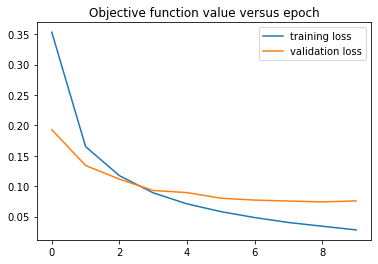

In [29]:
plt.plot(train_losses, label ='training loss')
plt.plot(test_losses, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('Objective function value versus epoch')
#if the validation loss starts increasing, we are overfitting the data

In [30]:
#computing our prediction accuracy on the validation dataset
num_correct = 0
model.eval()
for X_batch, Y_batch in dataloader_test:
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)
    
    with torch.no_grad(): #tells pytorch that it does not need to keep track of gradient info
        outputs = model(X_batch)
        num_correct += sum(np.argmax(outputs, axis = 1)== Y_batch)
        #the line above countrs how many predicted labels agree with teh ground truth labels
print('Accuracy = ' , num_correct/N_test)


Accuracy =  tensor(0.9783)
